In [3]:
!pip install deeplake

/bin/bash: pip: command not found


In [1]:
import deeplake


ModuleNotFoundError: No module named 'deeplake'

In [2]:
import os
import csv

def create_file_list_csv(directory, output_csv):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    # Create or overwrite the CSV file
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(['File Path', 'Filename', 'Class'])

        # Walk through the directory
        for subdir, dirs, files in os.walk(directory):
            for filename in files:
                # Create the full file path
                file_path = os.path.join(subdir, filename)
                # Infer the class from the subdirectory name
                file_class = os.path.basename(subdir)
                # Write the file details to the CSV
                writer.writerow([file_path, filename, file_class])

    print(f"CSV file created: {output_csv}")

# Usage example
directory_to_scan = '/projects/NEI/pranay/Eyes/Datasets/Diff_Generated_experiment_fid_50k'  # Replace with your directory path
output_csv_file = '/projects/NEI/pranay/Eyes/Datasets/Diff_Generated_experiment_fid_50k/data.csv'  # The output CSV file name
create_file_list_csv(directory_to_scan, output_csv_file)


CSV file created: /projects/NEI/pranay/Eyes/Datasets/Diff_Generated_experiment_fid_50k/data.csv


In [6]:
!pip install opencv-python 

     |████████████████████████████████| 92.9 MB 9.6 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for opencv-python: filename=opencv_python-4.9.0.80-cp36-cp36m-linux_x86_64.whl size=28991251 sha256=97eb522a793dc6ecbdfcbd834f535485349ee6efc2975553536e045375bdf253
  Stored in directory: /hawes/home/pranayjain/.cache/pip/wheels/0c/97/47/bc0f95ddefcfd9c58c29a5148e2c2fee523d431d8821e72cc3
Successfully built opencv-python


In [68]:
import numpy as np
import cv2
import os
from PIL import Image
from tqdm import tqdm

def detect_centered_circle_and_crop(img):
    """
    Scans horizontally and vertically from the edges towards the center of the image to find the edges of the centered circle.
    Returns a bounding box for the circle.
    """
    img_array = np.array(img)
    height, width = img_array.shape[:2]
    center_x, center_y = width // 2, height // 2

    # Convert to grayscale for easier processing
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # Define a function to find the edge in a scan line
    def find_edge_from_outside(scan_line, start_idx, end_idx, step):
        if abs(int(scan_line[start_idx])) > 10:
            return start_idx

        initial_value = int(scan_line[start_idx])
        for i in range(start_idx, end_idx, step):
            if abs(int(scan_line[i]) - initial_value) > 10:  # Threshold can be adjusted
                return i
        return end_idx

    # Find the edges from the outside towards the center
    left_edge = find_edge_from_outside(gray[center_y, :], 0, center_x, 1)
    right_edge = find_edge_from_outside(gray[center_y,:], width -1, center_x, -1)
    top_edge = find_edge_from_outside(gray[:,center_x], 0, center_y, 1)
    bottom_edge = find_edge_from_outside(gray[:,center_x], height -1, center_y, -1)
    # print(left_edge)
    # print(right_edge)
    # print(top_edge)
    # print(bottom_edge)

    # Ensure the crop coordinates are within the image boundaries
    left = max(left_edge, 0)
    top = max(top_edge, 0)
    right = min(right_edge, width)
    bottom = min(bottom_edge, height)

    # Crop and return
    return img.crop((left, top, right, bottom))



def pad_to_square(img):
    """
    Pad img (PIL Image) to make it square.
    """
    width, height = img.size
    size = max(width, height)
    new_img = Image.new("RGB", (size, size))
    new_img.paste(img, ((size - width) // 2, (size - height) // 2))
    return new_img

def find_black_border(img):
    """
    Find the bounding box of the non-black area in the image.
    """
    # Convert image to numpy array
    img_array = np.array(img)

    # Create a binary mask where non-black pixels are True
    non_black_mask = np.all(img_array >= [5, 5, 5], axis=-1)

    # Find non-zero rows and columns
    non_black_rows_percentage = np.mean(non_black_mask, axis=1)
    non_black_cols_percentage = np.mean(non_black_mask, axis=0)

    # Find rows and columns where the percentage of non-black pixels is greater than the threshold
    non_black_rows = non_black_rows_percentage > 0.005
    non_black_cols = non_black_cols_percentage > 0.005
    non_black_row_idx = np.where(non_black_rows)[0]
    non_black_col_idx = np.where(non_black_cols)[0]

    # Get bounding box
    if non_black_row_idx.size > 0 and non_black_col_idx.size > 0:
        return non_black_row_idx[0], non_black_row_idx[-1], non_black_col_idx[0], non_black_col_idx[-1]
    else:
        return 0, 0, 0, 0

def process_directory(input_dir, output_dir, threshold=5):
    """
    Process all images in a directory and its subdirectories, cropping uniform color borders.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for subdir, dirs, files in os.walk(input_dir):
        for filename in tqdm(files):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, filename)
                img = Image.open(img_path)
                # top, bottom, left, right = find_black_border(img)
                # cropped_img = img.crop((left, top, right + 1, bottom + 1))
                # square_img = pad_to_square(cropped_img)
                crop = pad_to_square(detect_centered_circle_and_crop(img))

                # Construct the output path by preserving the subdirectory structure
                relative_subdir = os.path.relpath(subdir, input_dir)
                output_subdir = os.path.join(output_dir, relative_subdir)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                save_path = os.path.join(output_subdir, filename)
                crop.save(save_path)

# Example usage
input_directory = '/projects/NEI/pranay/Eyes/Datasets/A. RFMiD_All_Classes_Dataset/1. Original Images'
output_directory = '/projects/NEI/pranay/Eyes/Datasets/A. RFMiD_All_Classes_Dataset/1. Original Images Processed 5'
process_directory(input_directory, output_directory)


0it [00:00, ?it/s]
  8%|▊         | 154/1905 [02:51<32:31,  1.11s/it] 


KeyboardInterrupt: 

In [31]:
file = '/projects/NEI/pranay/Eyes/Datasets/A. RFMiD_All_Classes_Dataset/1. Original Images Processed/a. Training Set/27.png'

In [40]:
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

for subdir, dirs, files in os.walk(input_directory):
    for filename in tqdm(files):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(subdir, filename)
            img = Image.open(img_path)
            # top, bottom, left, right = find_black_border(img)
            # cropped_img = img.crop((left, top, right + 1, bottom + 1))
            # square_img = pad_to_square(cropped_img)
            crop = detect_circle_and_crop(img)

            # Construct the output path by preserving the subdirectory structure
            relative_subdir = os.path.relpath(subdir, input_directory)
            output_subdir = os.path.join(output_directory, relative_subdir)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)

            save_path = os.path.join(output_subdir, filename)
            crop.save(save_path)

0it [00:00, ?it/s]
  0%|          | 0/1905 [00:00<?, ?it/s]/projects/NEI/pranay/Eyes/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ushort_scalars


returned original


  0%|          | 1/1905 [00:00<29:08,  1.09it/s]

returned original


  0%|          | 1/1905 [00:01<42:57,  1.35s/it]


KeyboardInterrupt: 

In [32]:
img = Image.open(file)
# top, bottom, left, right = find_black_border(img)
# cropped_img = img.crop((left, top, right + 1, bottom + 1))
# square_img = pad_to_square(cropped_img)
crop = pad_to_square(detect_circle_and_crop(img))

/projects/NEI/pranay/Eyes/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ushort_scalars


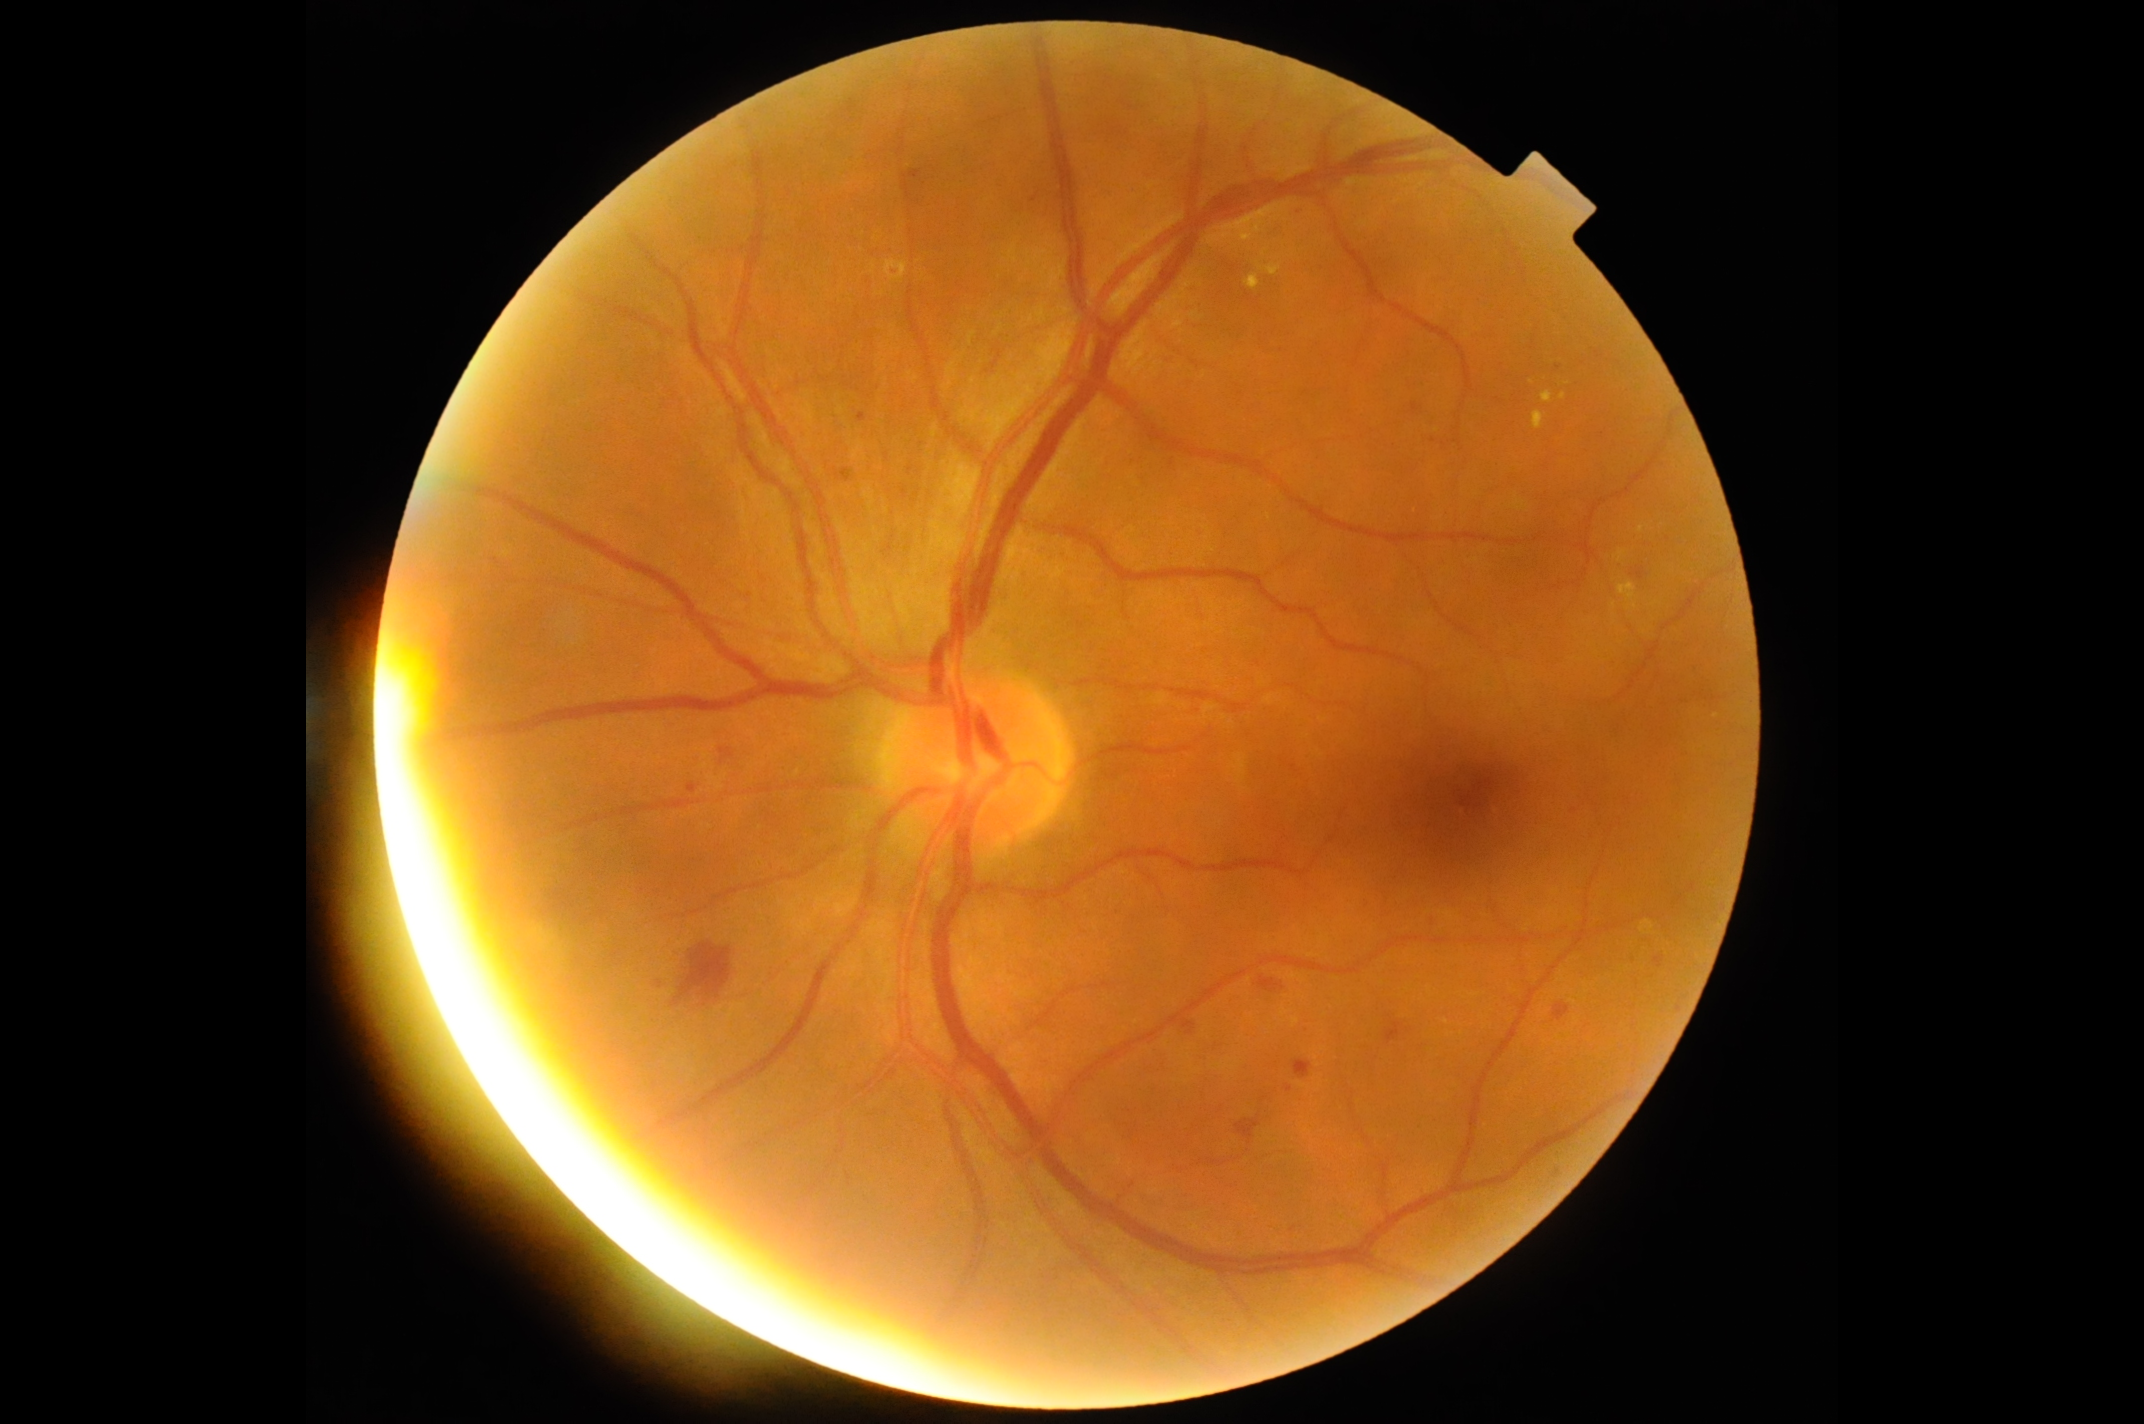

In [41]:
crop

In [33]:
/projects/NEI/pranay/Eyes/Datasets/A. RFMiD_All_Classes_Dataset/1. Original Images Processed 3/a. Training Set/1916.png

SyntaxError: invalid syntax (<ipython-input-33-2a57a7a5533d>, line 1)

In [ ]:
/projects/NEI/pranay/Eyes/Datasets/A. RFMiD_All_Classes_Dataset/1. Original Images Processed 3/a. Training Set/1907.png